# Collaboration Network
Creating the collaboration graph and collecting its data for CIAA-CIAA and CIAA-ALL datasets.
###### Nils Dyck, 11.05.2023

### CIAA-CIAA

In [226]:
import pandas as pd, networkx as nx, matplotlib.pyplot as plt

df = pd.read_csv('../data/cleaned/CIAA-CIAA.csv',sep=';')
df = df.loc[df['Year']<2022]

co_authors = df['Co-Author-URLs'].to_list()[:-1]
authors = df['Author-URL'].to_list()[:-1]
titles = df.drop_duplicates(subset='Title')

nodes = set(df['Author-URL'].to_list())
edges = []
l =[]

G = nx.Graph()
for i in range(len(authors)-1):
    entries = co_authors[i].replace('[','').replace(']','').replace('"','').replace("'",'') 
    entries = entries.split(', ')
    for entry in entries:
        G.add_edge(authors[i],entry)
        #edges.append([authors[i],entry])
        l.append(entry)

# edge_weights = {str(edge): edges.count(edge) for edge in set(edges)}
# max(edge_weights.values())

# for entries in co_authors:
#     entries = entries.replace('[','').replace(']','').replace('"','').replace("'",'') 
#     entries = entries.split(', ')
#     for entry in entries:
#         for j in range(len(entries)):
#             if entry != entries[j]:
#                 G.add_edge(entry,entries[j])

In [212]:
titles = df.drop_duplicates(subset='Title')
authors = titles['Author-URL'].to_list()
co_authors = titles['Co-Author-URLs'].to_list()

edges = {}

for i in range(len(co_authors)):
    entries = co_authors[i].replace('[','').replace(']','').replace('"','').replace("'",'') 
    entries = entries.split(', ')
    for j in range(len(entries)):
        for k in range(j+1,len(entries)):
            #check if edge already exists
            if (entries[j],entries[k]) not in edges:
                edges[(entries[j],entries[k])] = 0
            edges[(entries[j],entries[k])] += 1
edges = dict(sorted(edges.items(), key=lambda item: item[1], reverse=True))
top10_edges =list(edges.items())[:10]
print(len(titles))
print(len(co_authors))
print(len(edges))


687
687
446


### Deleting wrong node
There is one node right in the middle of the graph which has very much edges and is obviously wrong. It has to be excluded in the next few steps.

In [227]:
# Compute the degree of each node
degrees = dict(G.degree())

# Find the node with the highest degree
max_degree_node = max(degrees, key=degrees.get)

# Print the node with the highest degree and its degree
print("Node with the most edges:", max_degree_node)
print("Number of edges:", degrees[max_degree_node])

Node with the most edges: 
Number of edges: 146


In [228]:
# Choose a node to exclude
exclude_node = ''

# Create a new graph without the excluded node
new_G = nx.Graph()
new_G.add_nodes_from(n for n in G.nodes() if n != exclude_node)
new_G.add_edges_from((u, v) for u, v in G.edges() if u != exclude_node and v != exclude_node)

import json
with open('../data/raw/CIAA-nodes_all.json', 'w') as f:
    json.dump(list(new_G.nodes()),f)


In [229]:
G = new_G
edge_weights = {}
for edge in G.edges():
    weight_a = 0
    weight_b = 0
    entries = df.loc[df['Author-URL']==edge[0]]['Co-Author-URLs'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','').replace("'",'')
        entry = entry.split(', ')
        if edge[1] in entry: weight_a += 1
    entries = df.loc[df['Author-URL']==edge[1]]['Co-Author-URLs'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','')
        entry = entry.split(', ')
        if edge[0] in entry: weight_b += 1
    edge_weights[edge] = 2*max(weight_a, weight_b)


/var/folders/68/zr6z7wd56pl2hspyj9v4d57m0000gn/T/ipykernel_42236/4163065199.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv', len(components))


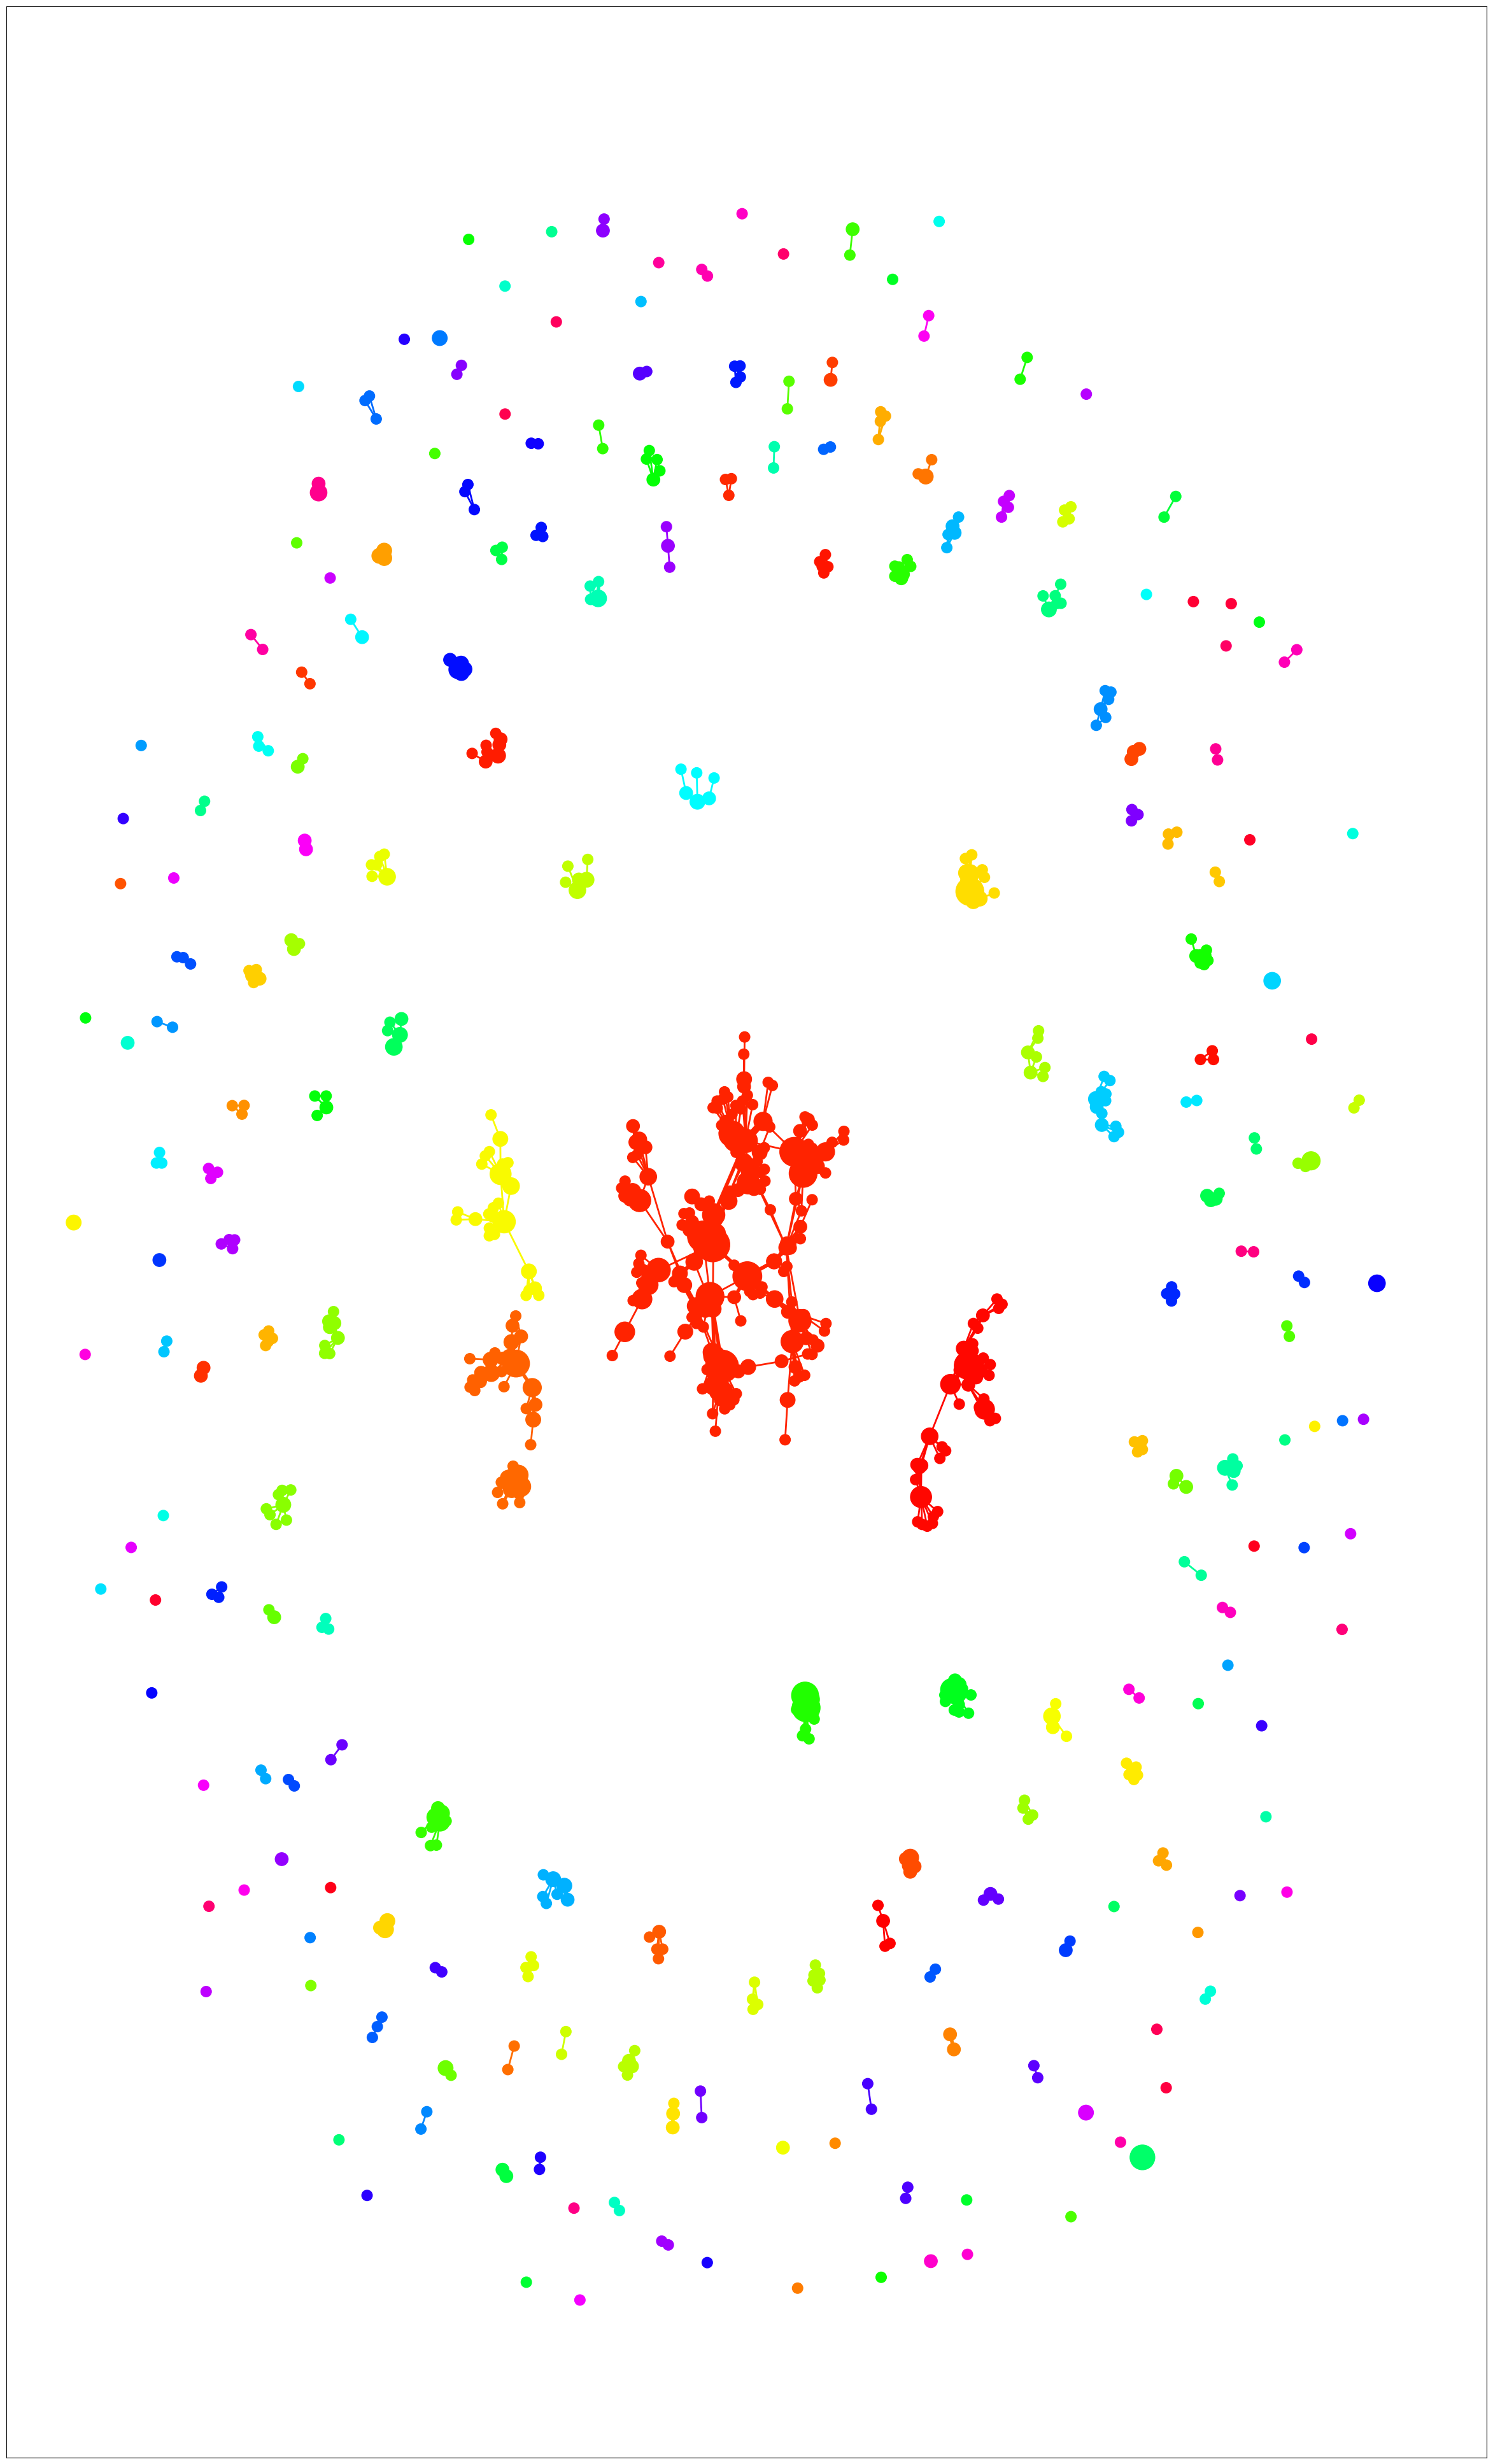

In [230]:
import matplotlib.cm as cm, random

ciaa_author_dict = pd.read_csv('../data/processed/CIAA-authors.csv', sep=';')
dcfs_author_dict = pd.read_csv('../data/processed/DCFS-authors.csv', sep=';')
ciaa_author_dict = {ciaa_author_dict['URL'].to_list()[i]: ciaa_author_dict['Name'].to_list()[i] for i in range(len(ciaa_author_dict['URL'].to_list()))}
dcfs_author_dict = {dcfs_author_dict['URL'].to_list()[i]: dcfs_author_dict['Name'].to_list()[i] for i in range(len(dcfs_author_dict['URL'].to_list()))}
def get_Name(url, venue):
    if venue == 'CIAA': return ciaa_author_dict[url]
    elif venue == 'DCFS': return dcfs_author_dict[url]
    else: return 'ERROR'

plt.figure(figsize=(30,50))

# Find connected components
components_0 = list(nx.connected_components(G))
components = sorted(components_0,key=len,reverse=True)
giant_component = components[0]
five_components = components[0:5]

# Set author names as labels isntead of urls
labels = {node: get_Name(node,'CIAA') for node in G.nodes() if node not in giant_component}
nx.set_node_attributes(G, labels, 'label')

# Set edge weights
nx.set_edge_attributes(G, edge_weights, 'weight')

# Generate a colormap based on the number of components
cmap = cm.get_cmap('hsv', len(components))

# Create a dictionary to store node-color mapping
node_colors = {}

# Assign colors to nodes based on connected components
for i, component in enumerate(components_0):
    color = cmap(i)
    for node in component:
        node_colors[node] = color

# Count occurrences of each node in the list
node_counts = {node: authors.count(node)+1 for node in G.nodes()}

# Compute node sizes based on counts
max_count = max(node_counts.values())
node_sizes = [count / max_count * 1500 for count in node_counts.values()]  # Adjust the scaling factor (500) as per your preference

# Set node sizes as attributes in the graph
node_size_dict = {node: size for node, size in zip(G.nodes(), node_sizes)}
nx.set_node_attributes(G, node_size_dict, 'node_size')

# Create a list to store edge colors
edge_colors = []

# Iterate over the edges and assign colors based on node colors
for edge in G.edges():
    node1, node2 = edge
    color1 = node_colors[node1]
    color2 = node_colors[node2]
    if color1 == color2:
        edge_colors.append(color1)
    else:
        edge_colors.append('black')  # Assign a different color for edges connecting nodes with different colors


# Draw the graph with node colors
pos = nx.spring_layout(G, iterations=40)
nx.draw_networkx(G, pos, node_color=[node_colors[node] for node in G.nodes()], node_size=list(node_sizes), width=[edge_weights[edge] for edge in G.edges()], edge_color=edge_colors, labels=labels, with_labels=False, font_size=6)

# Show the graph
plt.savefig('../../Figures/CIAA-CIAA.png',bbox_inches='tight')

192


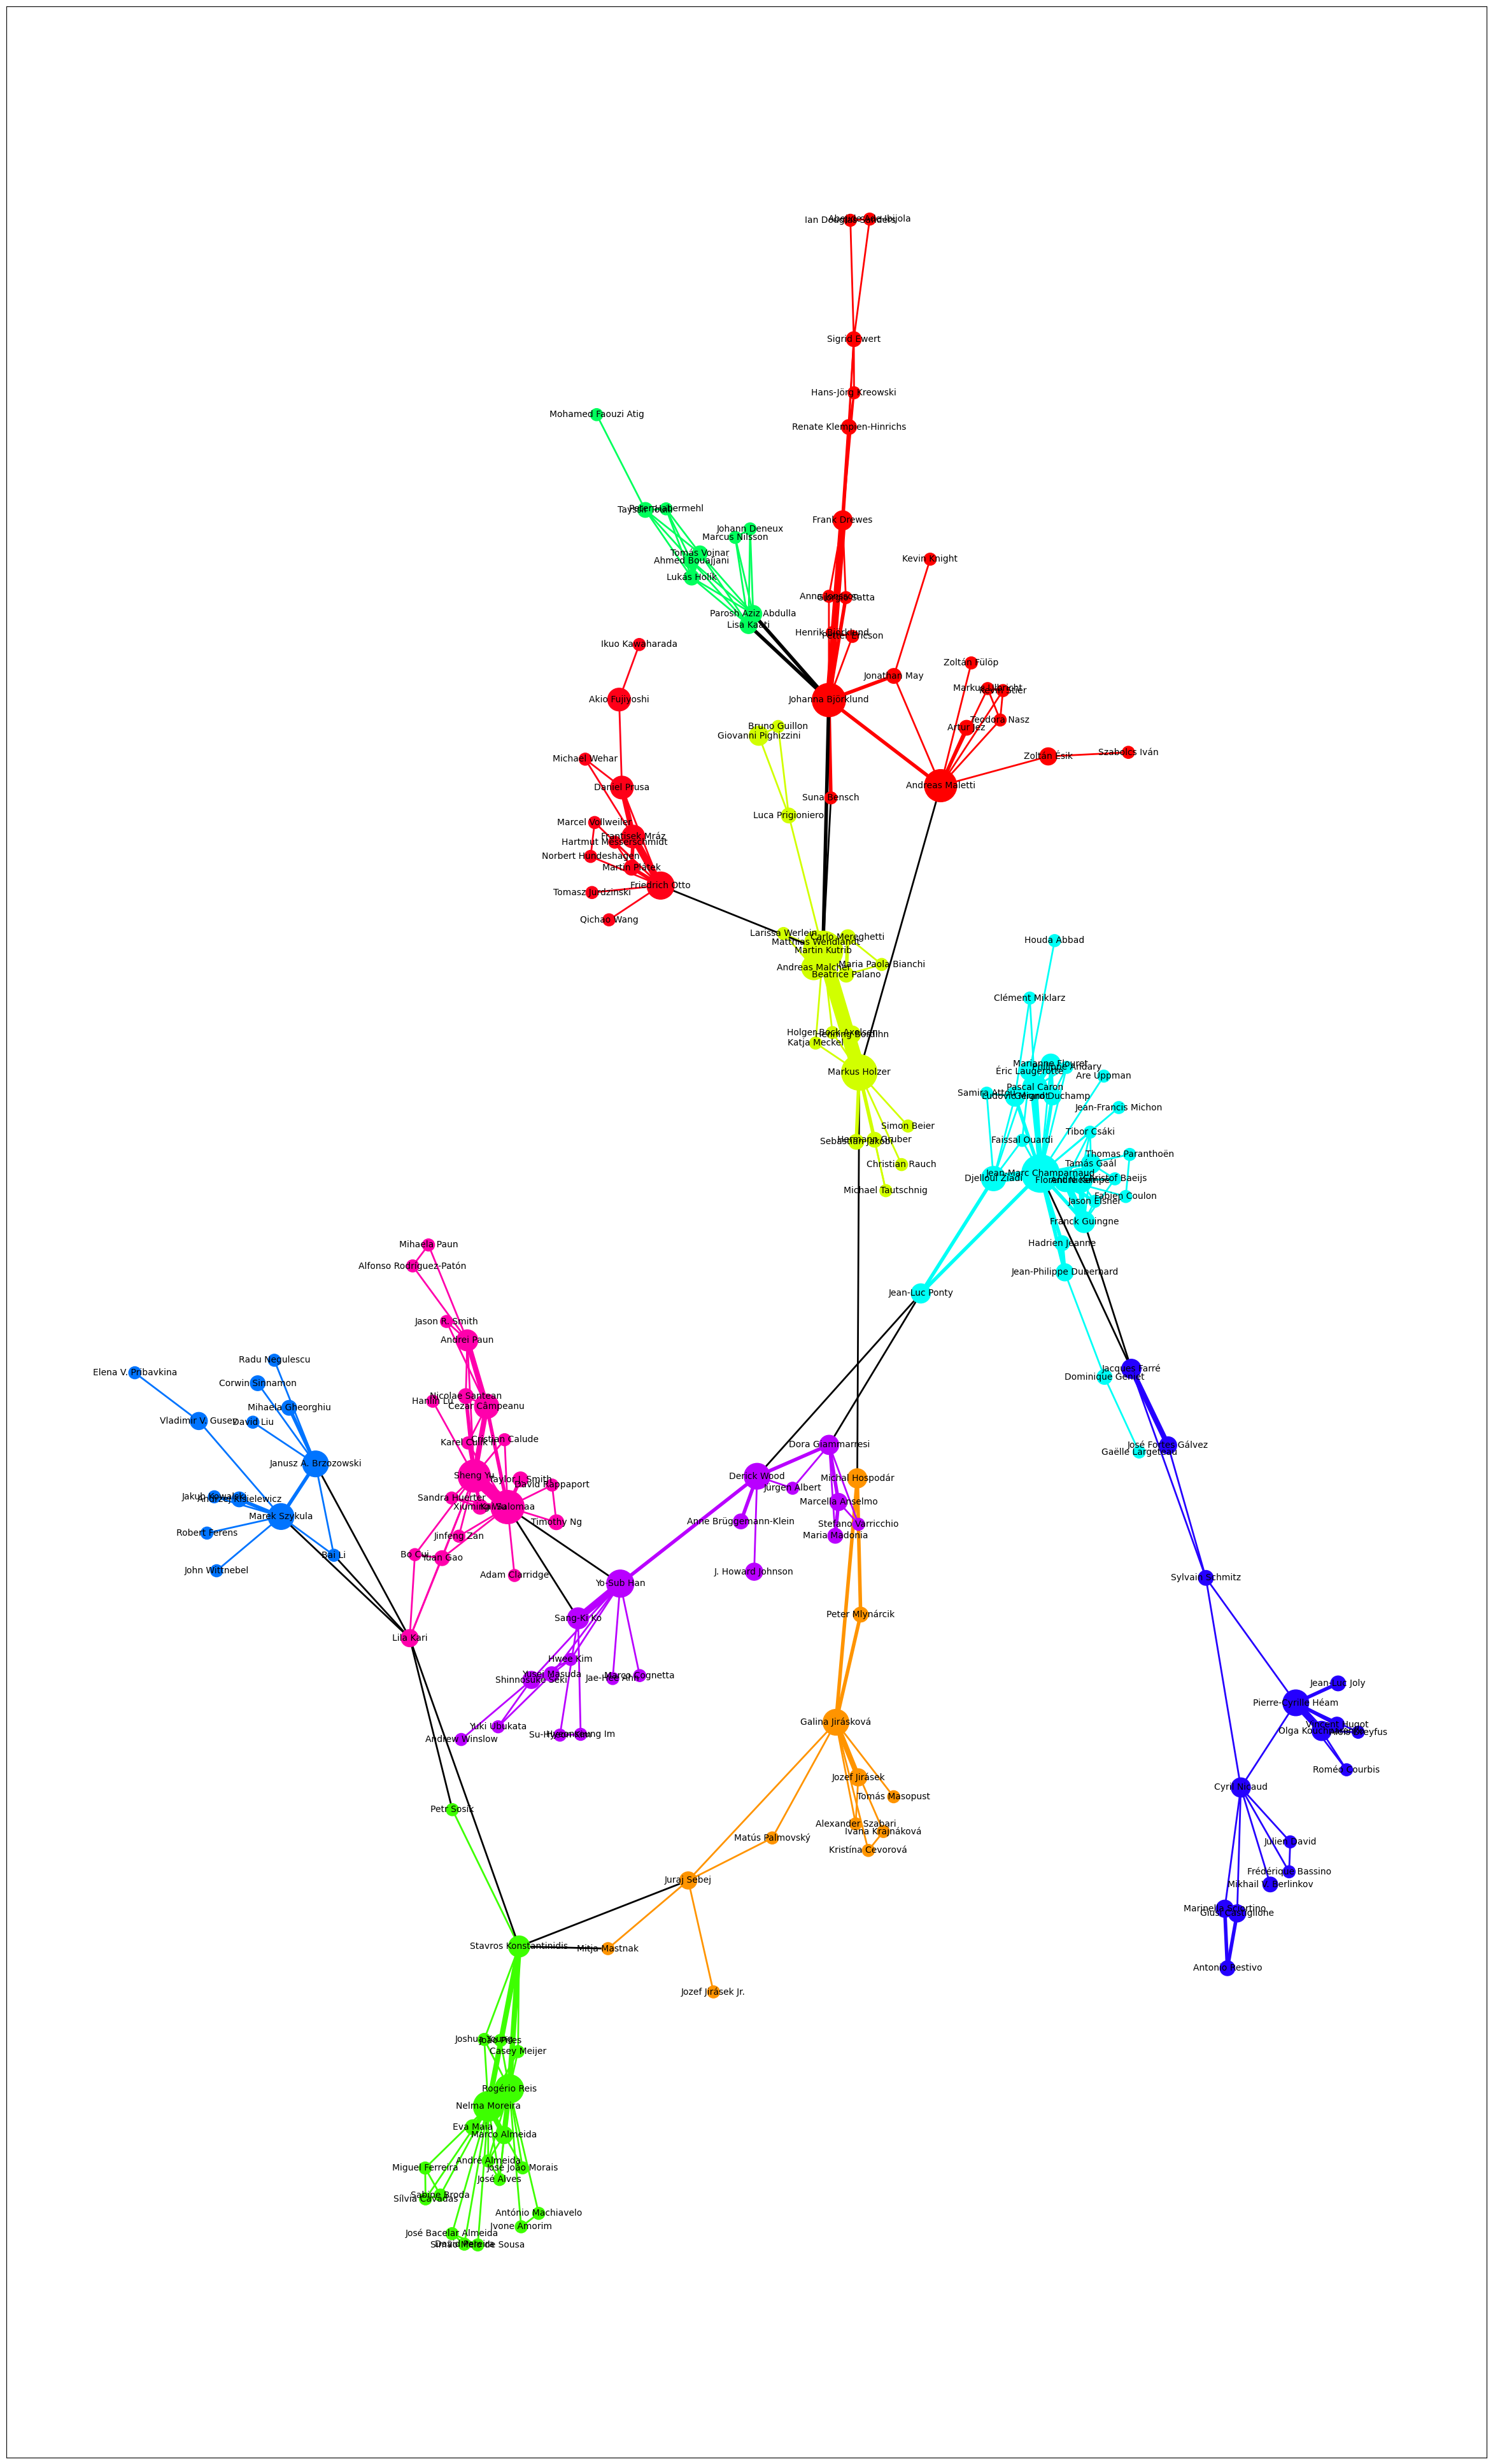

In [231]:
g = G.subgraph(giant_component)

plt.figure(figsize=(30,50))

# Compute edge weight
edge_weights = {}
for edge in g.edges():
    weight_a = 0
    weight_b = 0
    entries = df.loc[df['Author-URL']==edge[0]]['Co-Author-URLs'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','').replace("'",'')
        entry = entry.split(', ')
        if edge[1] in entry: weight_a += 1
    entries = df.loc[df['Author-URL']==edge[1]]['Co-Author-URLs'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','')
        entry = entry.split(', ')
        if edge[0] in entry: weight_b += 1
    edge_weights[edge] = 2*max(weight_a, weight_b)

# Set author names as labels instead of urls
labels = {node: get_Name(node,'CIAA') for node in g.nodes()}
nx.set_node_attributes(G, labels, 'label')

# Count occurrences of each node in the list
node_counts = {node: authors.count(node)+1 for node in g.nodes()}

# Compute node sizes based on counts
max_count = max(node_counts.values())
node_sizes = [count / max_count * 2000 for count in node_counts.values()]  # Adjust the scaling factor (500) as per your preference

# Set node sizes as attributes in the graph
node_size_dict = {node: size for node, size in zip(g.nodes(), node_sizes)}
nx.set_node_attributes(g, node_size_dict, 'node_size')

import community
# Find the communities
partition = community.best_partition(g)

# Create a color map
cmap = plt.get_cmap('hsv')
colors = []
color_dict = {}
for node in g.nodes():
    res = cmap(partition[node] / max(partition.values()))
    colors.append(res)
    color_dict[node] = res

# Iterate over the edges and assign colors based on node colors
edge_colors = []
for edge in g.edges():
    node1, node2 = edge
    color1 = color_dict[node1]
    color2 = color_dict[node2]
    if color1 == color2:
        edge_colors.append(color1)
    else:
        edge_colors.append('black')  # Assign a different color for edges connecting nodes with different colors

# Draw the graph
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, node_color=[color_dict[node] for node in g.nodes()], node_size=list(node_sizes), with_labels=True, labels=labels, width=[edge_weights[edge] for edge in g.edges()], edge_color=edge_colors, font_size=10)
#nx.draw_networkx(g,pos,labels=labels)
# Show the graph
plt.savefig('../../Figures/CIAA-CIAA_giant_component.png',bbox_inches='tight')

print(g.number_of_nodes())

TypeError: 'NoneType' object is not iterable

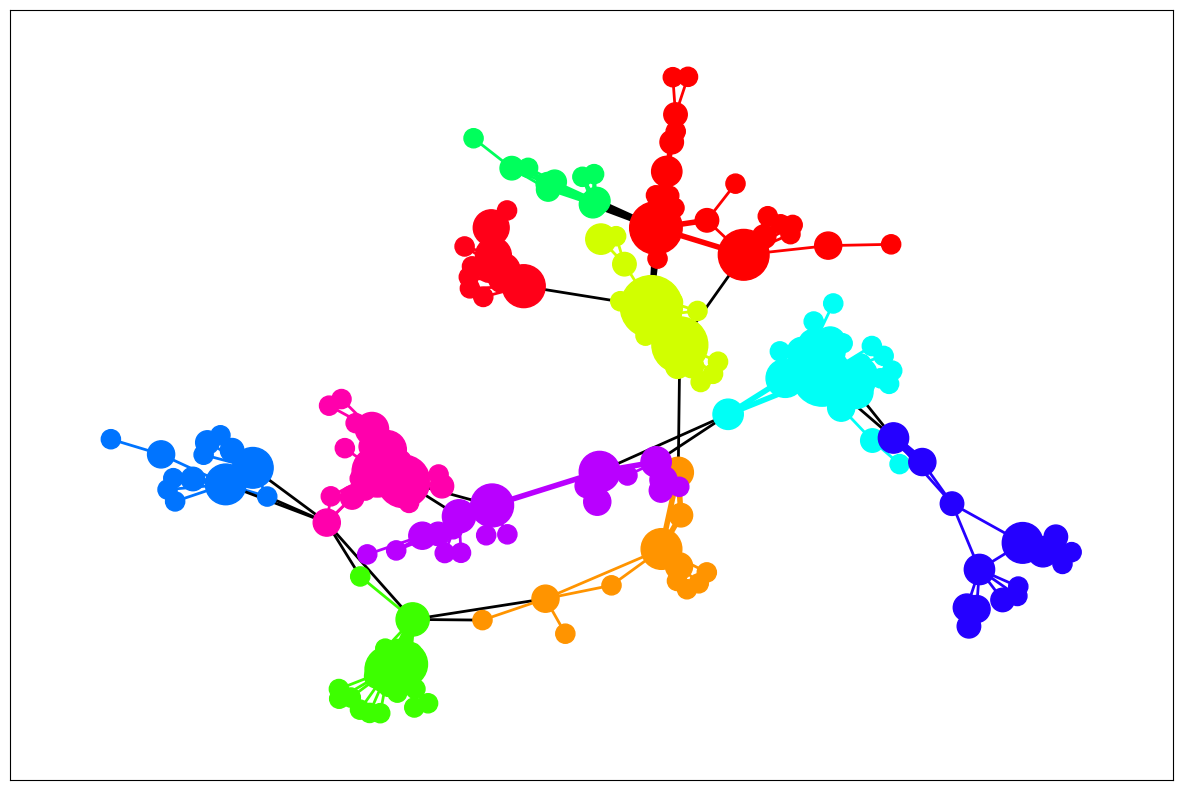

In [232]:
plt.figure(figsize=(15,10))
nx.draw_networkx(nx.draw_networkx(g, pos, node_color=[color_dict[node] for node in g.nodes()], node_size=list(node_sizes), with_labels=False, labels=labels, width=[edge_weights[edge] for edge in g.edges()], edge_color=edge_colors, font_size=10))
plt.savefig('../../Figures/CIAA-CIAA_giant_component_small.png',bbox_inches='tight')


In [130]:
for i in range(len(five_components)):
    print(str(i)+': '+str(len(five_components[i])/G.number_of_nodes()))

0: 0.22884386174016685
1: 0.04886769964243146
2: 0.029797377830750895
3: 0.028605482717520857
4: 0.014302741358760428


In [131]:
for component in five_components:
    g = G.subgraph(component)
    print(nx.diameter(g))

22
7
5
5
3


In [132]:
# Compute the degree of each node
degrees = dict(new_G.degree())

# Find the node with the highest degree
max_degree_node = max(degrees, key=degrees.get)

# Print the node with the highest degree and its degree
print("Node with the most edges:", max_degree_node)
print("Number of edges:", degrees[max_degree_node])

Node with the most edges: https://dblp.uni-trier.de/pid/30/6143.html
Number of edges: 22


In [133]:
n = new_G.number_of_nodes()
m = new_G.number_of_edges()
d = 2*m/(n*(n-1))
d

0.0030636540261306648

### Coloring Components

In [134]:
G = new_G
components = list(nx.connected_components(G))

# Create a color map
num_components = len(components)
colors = plt.cm.rainbow([i/num_components for i in range(num_components)])

# Assign a color to each node based on its component
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = colors[i]

# Draw the graph
plt.figure(figsize=(80,40))
nx.draw_kamada_kawai(G, node_color=[color_map[node] for node in G.nodes()], node_size=100, linewidths=0.1)
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 8000x4000 with 0 Axes>

In [135]:
nx.average_clustering(G)

0.5452797070496712

In [136]:
# Calculate betweenness centrality
def get_name(url):
    name = df.loc[df['Author-URL']==url]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
    return name

betweenness_centrality = nx.betweenness_centrality(G)

betweenness_sorted = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
betweenness_sorted = {get_name(key): value for key, value in betweenness_sorted.items()}

top10_betwenness = list(betweenness_sorted.items())[:10]

from tabulate import tabulate

headers = ['betweenness']
table1 = tabulate(top10_betwenness, headers, tablefmt='latex')
print(table1)

\begin{tabular}{lr}
\hline
                        &   betweenness \\
\hline
 Stavros Konstantinidis &     0.0298401 \\
 Lila Kari              &     0.0290816 \\
 Galina Jirásková       &     0.025101  \\
 Juraj Sebej            &     0.0247674 \\
 Kai Salomaa            &     0.0244542 \\
 Markus Holzer          &     0.0239719 \\
 Yo-Sub Han             &     0.0232761 \\
 Michal Hospodár        &     0.0229938 \\
 Derick Wood            &     0.0207041 \\
 Jean-Luc Ponty         &     0.0181464 \\
\hline
\end{tabular}


### Draw the giant component only.

In [137]:
plt.figure(figsize=(60,30))
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)
plt.figure(figsize=(60,30))
nx.draw_kamada_kawai(subgraph, node_size=100, linewidths=0.1)
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

In [138]:
subgraph.number_of_edges()

344

The number of nodes is the same as shown by ghr !!!!

In [139]:
subgraph.number_of_nodes()

192

### Draw the giant component with its communities.

In [140]:
import community
# Find the communities
partition = community.best_partition(subgraph)

# Create a color map
cmap = plt.get_cmap('hsv')
colors = [cmap(partition[node] / max(partition.values())) for node in subgraph.nodes()]

# Draw the graph
plt.figure(figsize=(60,30))
nx.draw_kamada_kawai(subgraph, node_color=colors, node_size=2000, linewidths=0.2)
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 6000x3000 with 0 Axes>

Find the largest community.

In [141]:
# Count the number of nodes in each community
community_sizes = {}
for node, community_label in partition.items():
    if community_label not in community_sizes:
        community_sizes[community_label] = 0
    community_sizes[community_label] += 1

# Find the largest community
largest_community_label = max(community_sizes, key=community_sizes.get)
largest_community_size = community_sizes[largest_community_label]

print("The largest community is labeled as", largest_community_label, "and contains", largest_community_size, "nodes.")

The largest community is labeled as 5 and contains 28 nodes.


In [142]:
# Extract largest community for use in other notebooks.
import json
ciaa_communities = []
for i in range(1,max(partition.values())+1):
    this_community = [key for key in partition.keys() if partition[key] == i]
    ciaa_communities.append(this_community)

with open('../data/raw/CIAA-communities.json', 'w') as f:
    json.dump(ciaa_communities,f)


Adjusting node sizes and line widths depending on published papers and collaborations.

In [143]:
G = subgraph
authors = df['Author-URL'].to_list()
nodes = list(G.nodes())
weight = {node: authors.count(node) for node in nodes}
nx.set_node_attributes(G, weight, 'weight')
node_sizes = [50 * G.nodes[node]['weight'] for node in G.nodes()]

edges= list(G.edges())
edge_sizes = {edge: edges.count(edge) for edge in edges}
    

In [144]:
# Draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, node_color=colors, node_size=node_sizes, widths=[edge_weights[node] for node in G.nodes()], labels=labels, with_labels=True)
plt.show()

KeyError: 'https://dblp.uni-trier.de/pid/152/0486.html'

<Figure size 1000x1000 with 0 Axes>

### Identifying node roles

In [26]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor

# extract features
feature_extractor = RecursiveFeatureExtractor(G)
features = feature_extractor.extract_features()

print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
print(features)


Features extracted from 4 recursive generations:
                                                    external_edges(mean)(mean)(mean)  \
https://dblp.uni-trier.de/pid/00/4758.html                                 17.061685   
https://dblp.uni-trier.de/pid/00/5474.html                                  9.927083   
https://dblp.uni-trier.de/pid/00/7175.html                                 14.932581   
https://dblp.uni-trier.de/pid/01/4388.html                                 11.520833   
https://dblp.uni-trier.de/pid/01/880.html                                   7.449074   
...                                                                              ...   
https://dblp.uni-trier.de/pid/l/GaelleLargeteau...                          7.166667   
https://dblp.uni-trier.de/pid/n/NelmaMoreira.html                          16.242115   
https://dblp.uni-trier.de/pid/s/NicolaeSantean....                         15.946022   
https://dblp.uni-trier.de/pid/w/DerickWood.html                       

In [28]:
# assign node roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

print('\nNode role assignments:')
print(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors=len(unique_roles))
# map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in G.nodes]

In [ ]:
# plot graph
plt.figure()

with warnings.catch_warnings():
    # catch matplotlib deprecation warning
    warnings.simplefilter('ignore')
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=node_colors,
    )

plt.show()

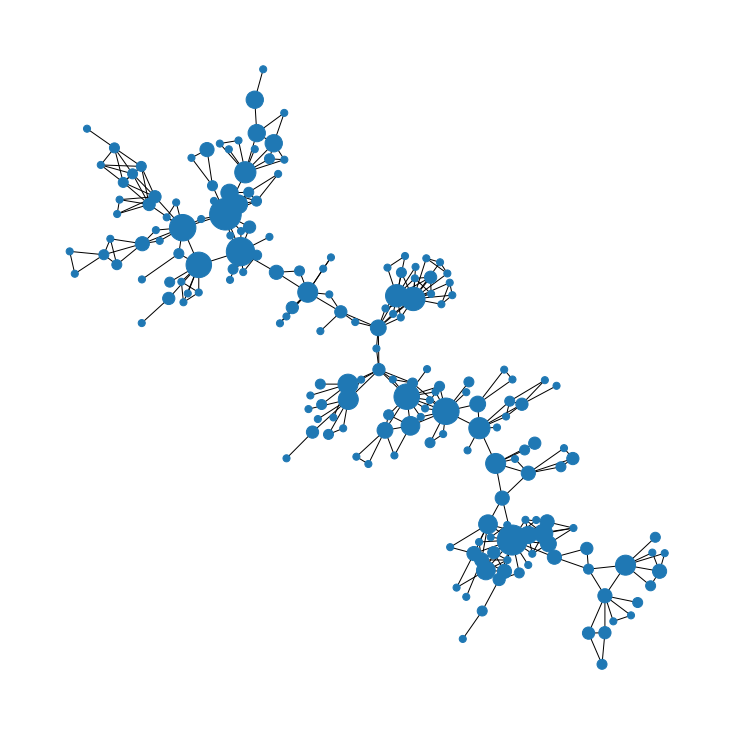

In [20]:
# Draw the graph
plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(G, node_size=node_sizes, linewidths=1)
plt.show()

In [21]:
G.number_of_nodes()

192

In [22]:
len(components)

219

In [23]:
nx.diameter(G)

22

In [24]:
import json

# Save the dictionary to a file
with open('../data/raw/CIAA-communities.json', 'w') as f:
    json.dump(partition, f)

with open('../data/raw/CIAA-nodes.json', 'w') as f:
    json.dump(list(G.nodes()),f)

import pickle

with open('../data/raw/CIAA_components.pkl', 'wb') as f:
    pickle.dump(components, f)


### Calcutlating edge width.

In [25]:
graph = nx.Graph()

# Add edges with weights to the graph
for (node1, node2), weight in edges.items():
    graph.add_edge(node1, node2, weight=weight)

# Get the weights of the edges
weights = [graph[u][v]['weight'] for u, v in graph.edges()]

# Set the widths of the edges based on their weights
widths = [0.5 + 2 * (weight - min(weights)) / (max(weights) - min(weights)) for weight in weights]

# Draw the graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=50, font_size=10, width=widths)

# Show the graph
plt.show()

AttributeError: 'list' object has no attribute 'items'

In [ ]:
graph.number_of_nodes()

411

In [ ]:
nodes = list(G.nodes())
len(nodes)
len(set(authors))

414

In [ ]:
# Choose a node to exclude
exclude_node = ''

# Create a new graph without the excluded node
new_G = nx.Graph()
new_G.add_nodes_from(n for n in graph.nodes() if n != exclude_node)
new_G.add_edges_from((u, v) for u, v in graph.edges() if u != exclude_node and v != exclude_node)

NetworkXError: Node 'https://dblp.uni-trier.de/pid/n/NelmaMoreira.html' has no position.

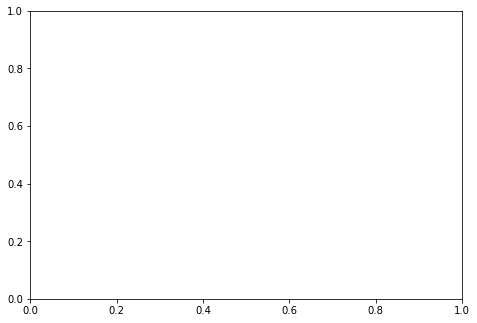

In [ ]:
G = new_G
components = list(nx.connected_components(G))

# Create a color map
num_components = len(components)
colors = plt.cm.rainbow([i/num_components for i in range(num_components)])

# Assign a color to each node based on its component
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = colors[i]

largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)

import community
# Find the communities
partition = community.best_partition(subgraph)

# Create a color map
cmap = plt.get_cmap('hsv')
colors = [cmap(partition[node] / max(partition.values())) for node in subgraph.nodes()]

G = subgraph
nodes = list(G.nodes())
weight = {node: authors.count(node) for node in nodes}
nx.set_node_attributes(G, weight, 'weight')
node_sizes = [25 * G.nodes[node]['weight'] for node in G.nodes()]

# Draw the graph
pos = nx.random_layout(subgraph)
nx.draw(graph, pos, node_color=colors, node_size=node_sizes, font_size=10, width=widths)

# Show the graph
plt.show()